<a href="https://colab.research.google.com/github/haresh93/ERA-submissions/blob/main/S7/Step_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **TARGET**
1. Getting the skeleton right
2. Making the model lighter
3. Adding Batch Normalization to push Model's accuracy
4. Without any regularization

### **RESULTS**
1. Parameters: 9.9k
2. Best Training Accuracy: 99.97%
3. Best Test Accuracy: 99.31%

### **Analysis**
1. The model parameters have been drastically reduced.
2. Model is overfitted as we see that after 10 epochs the training accuracy was increasing but the it is not getting transferred into the test accuracy which is a sign of overfitting

In [2]:
!pip3 install torch
!pip3 install torchvision
!pip3 install matplotlib
!pip3 install torchsummary
!pip3 install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [4]:
cuda = torch.cuda.is_available()
print("Cuda Available: ", cuda)

device = torch.device("cuda" if cuda else "cpu")

Cuda Available:  True


In [5]:
# Train and Test Transforms
train_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
])

test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
])

In [6]:
# Train and Test Datasets
train_dataset = datasets.MNIST('../data', train=True, download=True,
                    transform=train_transforms)
test_dataset = datasets.MNIST('../data', train=False, download=True,
                    transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 138007911.03it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 127915199.39it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 44620381.41it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20752209.99it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [7]:
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 4, pin_memory = True)

train_dataloader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)

test_dataloader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
from utils import print_train_data_stats

print_train_data_stats()

100%|██████████| 9912422/9912422 [00:00<00:00, 150147567.32it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 134595215.36it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 53261849.69it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 2028810.31it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [9]:
from model import model_summary, Net2

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net2().to(device)

model_summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]             584
              ReLU-5            [-1, 8, 24, 24]               0
       BatchNorm2d-6            [-1, 8, 24, 24]              16
            Conv2d-7            [-1, 8, 22, 22]             584
              ReLU-8            [-1, 8, 22, 22]               0
       BatchNorm2d-9            [-1, 8, 22, 22]              16
        MaxPool2d-10            [-1, 8, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           1,168
             ReLU-12             [-1, 16, 9, 9]               0
      BatchNorm2d-13             [-1, 16, 9, 9]              32
           Conv2d-14             [-1, 1

In [10]:
from model import Net1, model_train, model_test, draw_graphs
model =  Net2().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    model_train(model, device, train_dataloader, optimizer, epoch)
    model_test(model, device, test_dataloader)

EPOCH: 0


Train: Loss=0.0704 Batch_id=468 Accuracy=95.80: 100%|██████████| 469/469 [00:17<00:00, 26.83it/s]



Test set: Average loss: 0.0542, Accuracy: 9833/10000 (98.33%)

EPOCH: 1


Train: Loss=0.0180 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]



Test set: Average loss: 0.0339, Accuracy: 9882/10000 (98.82%)

EPOCH: 2


Train: Loss=0.0078 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:17<00:00, 27.30it/s]



Test set: Average loss: 0.0317, Accuracy: 9883/10000 (98.83%)

EPOCH: 3


Train: Loss=0.0516 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:16<00:00, 28.60it/s]



Test set: Average loss: 0.0297, Accuracy: 9898/10000 (98.98%)

EPOCH: 4


Train: Loss=0.0031 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]



Test set: Average loss: 0.0267, Accuracy: 9903/10000 (99.03%)

EPOCH: 5


Train: Loss=0.0328 Batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:16<00:00, 29.02it/s]



Test set: Average loss: 0.0250, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Train: Loss=0.0145 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:16<00:00, 28.59it/s]



Test set: Average loss: 0.0232, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Train: Loss=0.0017 Batch_id=468 Accuracy=99.54: 100%|██████████| 469/469 [00:16<00:00, 28.41it/s]



Test set: Average loss: 0.0226, Accuracy: 9922/10000 (99.22%)

EPOCH: 8


Train: Loss=0.0059 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:16<00:00, 28.55it/s]



Test set: Average loss: 0.0272, Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Train: Loss=0.0027 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:17<00:00, 27.31it/s]



Test set: Average loss: 0.0252, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Train: Loss=0.0034 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]



Test set: Average loss: 0.0254, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


Train: Loss=0.0103 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:16<00:00, 27.94it/s]



Test set: Average loss: 0.0255, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Train: Loss=0.0059 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:16<00:00, 28.26it/s]



Test set: Average loss: 0.0300, Accuracy: 9911/10000 (99.11%)

EPOCH: 13


Train: Loss=0.0001 Batch_id=468 Accuracy=99.82: 100%|██████████| 469/469 [00:17<00:00, 26.75it/s]



Test set: Average loss: 0.0246, Accuracy: 9921/10000 (99.21%)

EPOCH: 14


Train: Loss=0.0063 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:16<00:00, 28.03it/s]



Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)

EPOCH: 15


Train: Loss=0.0037 Batch_id=468 Accuracy=99.90: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]



Test set: Average loss: 0.0246, Accuracy: 9927/10000 (99.27%)

EPOCH: 16


Train: Loss=0.0015 Batch_id=468 Accuracy=99.91: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]



Test set: Average loss: 0.0261, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Train: Loss=0.0019 Batch_id=468 Accuracy=99.93: 100%|██████████| 469/469 [00:17<00:00, 26.55it/s]



Test set: Average loss: 0.0250, Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Train: Loss=0.0051 Batch_id=468 Accuracy=99.95: 100%|██████████| 469/469 [00:16<00:00, 27.77it/s]



Test set: Average loss: 0.0261, Accuracy: 9923/10000 (99.23%)

EPOCH: 19


Train: Loss=0.0002 Batch_id=468 Accuracy=99.97: 100%|██████████| 469/469 [00:17<00:00, 27.14it/s]



Test set: Average loss: 0.0270, Accuracy: 9925/10000 (99.25%)



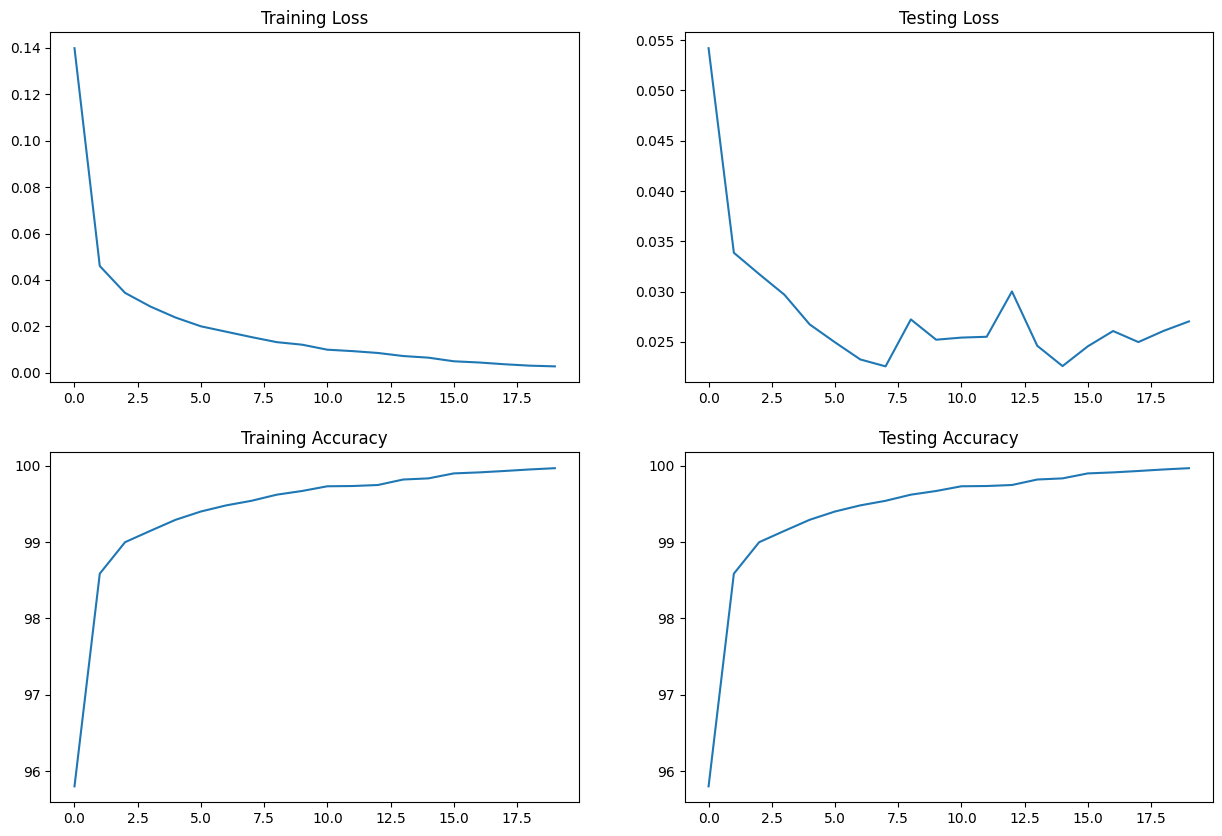

In [11]:
draw_graphs()